In [13]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

In [14]:
import os
import numpy as np

from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo_keras.utils import *
from yolo_keras.model import *
from PIL import Image

from util import *

import argparse
import random
import matplotlib.patches as patches
import matplotlib.pyplot as plt


classes_path = "/faceml/yolo_keras/coco_classes.txt"
anchors_path = "/faceml/yolo_keras/yolo_anchors.txt"
model_path="/faceml/yolo_keras/yolo.h5"

with open(classes_path) as f:
    class_names = f.readlines()
    class_names = [c.strip() for c in class_names] 
num_classes = len(class_names)
print(class_names)
# Get the anchor box coordinates for the model

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)

# Set the expected image size for the model
model_image_size = (416, 416)


# Create YOLO model
#home = os.path.expanduser("~")
#model_path = os.path.join(home, "yolo.h5")
yolo_model = load_model(model_path, compile=False)

# Generate output tensor targets for bounding box predictions
# Predictions for individual objects are based on a detection probability threshold of 0.3
# and an IoU threshold for non-max suppression of 0.45
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_model.output, anchors, len(class_names), input_image_shape,
                                    score_threshold=0.3, iou_threshold=0.45)

print("YOLO model ready!")

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
YOLO model ready!


In [15]:
def detect_objects(image):
    
    # normalize and reshape image data
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    # Predict classes and locations using Tensorflow session
    sess = K.get_session()
    out_boxes, out_scores, out_classes = sess.run(
                [boxes, scores, classes],
                feed_dict={
                    yolo_model.input: image_data,
                    input_image_shape: [image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })
    return out_boxes, out_scores, out_classes

def show_objects(image, out_boxes, out_scores, out_classes, fig, imgnum):
    
    # Set up some display formatting
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Plot the image
    img = np.array(image)
    ax = fig.add_subplot(1, 2, imgnum)
    ax.imshow(img)

    # Set up padding for boxes
    img_size = model_image_size[0]
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    # Use a random color for each class
    unique_labels = np.unique(out_classes)
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # process each instance of each class that was found
    for i, c in reversed(list(enumerate(out_classes))):
        # Get the class name
        predicted_class = class_names[c]
        # Get the box coordinate and probability score for this instance
        box = out_boxes[i]
        score = out_scores[i]

        # Format the label to be added to the image for this instance
        label = '{} {:.2f}'.format(predicted_class, score)

        # Get the box coordinates
        top, left, bottom, right = box
        y1 = max(0, np.floor(top + 0.5).astype('int32'))
        x1 = max(0, np.floor(left + 0.5).astype('int32'))
        y2 = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        x2 = min(image.size[0], np.floor(right + 0.5).astype('int32'))

        # Set the box dimensions
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        
        # Add a box with the color for this class
        color = bbox_colors[int(np.where(unique_labels == c)[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        
    

In [16]:
def show_image(im, x1, y1, x2, y2, fig, imgnum):
    ax = fig.add_subplot(1, 2, imgnum)
    ax.imshow(im)
    if (x1 is None):
        return
    for i in range(len(x1)):
        rect = patches.Rectangle((x1[i],y1[i]),x2[i]-x1[i],y2[i]-y1[i],linewidth=1,edgecolor='r',facecolor='none', label=i)
        centerx = x1[i] + (x2[i]-x1[i])/2
        centery = y1[i] + (y2[i]-y1[i])/2
        ax.text(centerx, centery,str(i), color='white')
        # Add the patch to the Axes
        ax.add_patch(rect)


def getBoxAreas(objects, out_classes, classes, out_scores, out_boxes, image_area, requiredConfidence, requiredSize):
    matchedConfidence, matchedSize=0,0
    filter_boxes, filter_scores, filter_objects, areas =[],[],[],[]
    for i in range(len(out_classes)):
        if (objects[i] in classes and out_scores[i]*100>=requiredConfidence):
            matchedConfidence=matchedConfidence+1
            box_height=(out_boxes[i][2]-out_boxes[i][0])
            box_width=(out_boxes[i][3]-out_boxes[i][1])
            box_area=box_width*box_height
            areas.append(box_area)
            filter_boxes.append(out_boxes[i])
            filter_scores.append(out_scores[i])
            filter_objects.append(out_classes[i])
            if ((box_area/image_area)*100 > requiredSize):
                matchedSize=matchedSize+1

    return matchedConfidence, matchedSize, areas, filter_boxes, filter_scores, filter_objects


def checkPortrait(areasDiff, requiredCount, portraitDiff):
    return (areasDiff[requiredCount-1]*100 > portraitDiff)

def checkGroupOrSelfie(areasDiff, groupDiff):
    countOverGroupDiff=0
    for i in range(len(areasDiff)):
        if (areasDiff[i]*100 > groupDiff):
            countOverGroupDiff=countOverGroupDiff+1
    return (countOverGroupDiff==0), (countOverGroupDiff==1) 

#find if portrait, group or selfie
def categorizeImage(areas, requiredCount, portraitDiffDefault, groupDiffDefault, portraitDiff, groupDiff):

    isPortrait=(portraitDiff >0)
    isGroup=(groupDiff >0)
    sortedareas = sorted(areas,reverse=True)
    areasDiff = list((sortedareas[i]-sortedareas[i+1])/sortedareas[i+1] for i in range(len(sortedareas)-1))
    
    if (not (isPortrait or isGroup)):
        bPortrait=checkPortrait(areasDiff, max(requiredCount,1), portraitDiffDefault)
        bGroup, bSelfie=checkGroupOrSelfie(areasDiff,groupDiffDefault)
        return bPortrait, bGroup, bSelfie

    if (isPortrait):
        requiredCount = max(requiredCount,1)
        isPortrait=checkPortrait(areasDiff, requiredCount, portraitDiff)
        return isPortrait, False, False

    if (isGroup):
        isGroup, isSelfie = checkGroupOrSelfie(areasDiff,groupDiff)
        return False, isGroup, isSelfie  

    return (False,)*3    

In [17]:
import os
from numpy import asarray
from PIL import Image

def detectObjects(image_file, classname, requiredConfidence=80, requiredSize=5,
                  requiredCount=0,portraitDiff=0,groupDiff=0,selfieDiff=0,
                  portraitDiffDefault=150, groupDiffDefault=150):
    isPortrait=(portraitDiff >0 and requiredCount > 0)
    isGroup=(groupDiff >0)

    # Load image
    orgimage = Image.open(image_file)

    # Resize image for model input
    image = letterbox_image(orgimage, tuple(reversed(model_image_size)))
    iw, ih = image.size
    image_area=iw*ih

    # Detect objects in the image
    out_boxes, out_scores, out_classes = detect_objects(image)
    objects=[class_names[out_classes[i]] for i in range(len(out_classes))]

    fig = plt.figure(figsize=(16,9), facecolor="white")
    search_classes, not_classes, expr = processClassName(classname)
    if (eval(expr)):
        matchedConfidence=0
        matchedSize=0
        sortindexes=None
        matchedConfidence, matchedSize =0,0 
        areas, filter_boxes, filter_scores, filter_objects=[],[],[],[]
        if (search_classes!=[]):
            matchedConfidence, matchedSize, areas, filter_boxes, filter_scores, filter_objects = \
                getBoxAreas(objects, out_classes, search_classes, out_scores, out_boxes, image_area, \
                            requiredConfidence, requiredSize)
            print(image_file, ": Found ", matchedConfidence, " count of ", search_classes, " objects with ", matchedSize, " greater than ", requiredSize, "%")
            if(len(areas) > 1 and matchedSize > 0):
                isPortrait, isGroup, isSelfie = categorizeImage(areas, requiredCount, portraitDiffDefault, groupDiffDefault, portraitDiff, groupDiff)
                print("matched as portrait" if isPortrait else "matched as group" if isGroup else "matched as selfie" if isSelfie else "")

        if (not_classes!=[]):
            print(image_file, ": No ", not_classes, " objects found")

        sortedareas = sorted(areas,reverse=True)
        if(len(sortedareas) > 1):
            areasDiff = list((sortedareas[i]-sortedareas[i+1])/sortedareas[i+1] for i in range(len(sortedareas)-1))

        print("%Areas:",end=" ")
        for i in range(len(sortedareas)):
            print(round(sortedareas[i]*100/image_area,4), end=" ")
        print("%Diff:", end=" ")
        for i in range(len(sortedareas)-1):
            print(round((sortedareas[i]-sortedareas[i+1])*100/sortedareas[i+1],4), end=" ")

        if (matchedSize>0):    
            sortindexes = np.argsort(areas)[::-1]
            sortindexes = sortindexes[:matchedSize]
            filter_boxes=asarray(filter_boxes)[sortindexes]
            filter_scores=asarray(filter_scores)[sortindexes]
            filter_objects=asarray(filter_objects)[sortindexes]
            if (filter_objects.ndim==2):
                filter_boxes=filter_boxes[0]
                filter_scores=filter_scores[0]
                filter_objects=filter_objects[0]
                
        show_objects(image, filter_boxes, filter_scores, filter_objects, fig, 1) 
        plt.axis("off")

        if (matchedSize>0):
            k=np.concatenate( filter_boxes, axis=0 )    
            k=k.reshape(matchedSize,4)
            show_image(image, k[:,1],k[:,0],k[:,3],k[:,2], fig, 2)
            plt.axis("off")
    else:
        print('Found {} objects in {}'.format(len(out_boxes), image_file))

        # Display the image with bounding boxes
        show_objects(image, out_boxes, out_scores, out_classes, fig, 1)
        plt.axis("off")
        objects=[class_names[out_classes[i]] for i in range(len(out_classes))]
        print(objects)    
    
    plt.show()

/faceml/sampleimages/extractfaces/bond.jpg : Found  6  count of  ['person']  objects with  6  greater than  5 %
matched as group
%Areas: 13.1017 12.6568 12.2455 12.0968 11.7283 8.5342 %Diff: 3.5146 3.3596 1.2287 3.1421 37.4275 

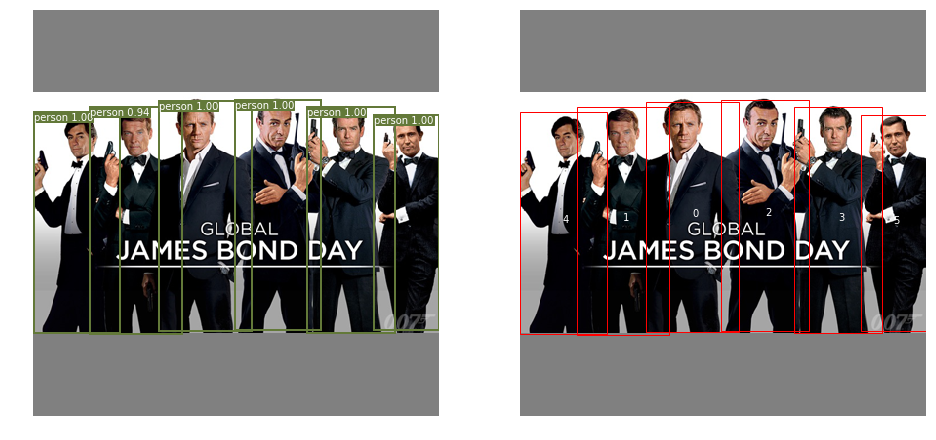

In [18]:
#match as group    
detectObjects("/faceml/sampleimages/extractfaces/bond.jpg", classname="person",groupDiff=100)

/faceml/sampleimages/pierce2.jpg : Found  3  count of  ['person']  objects with  2  greater than  2 %
matched as portrait
%Areas: 39.7612 4.3363 0.7475 %Diff: 816.9475 480.1314 

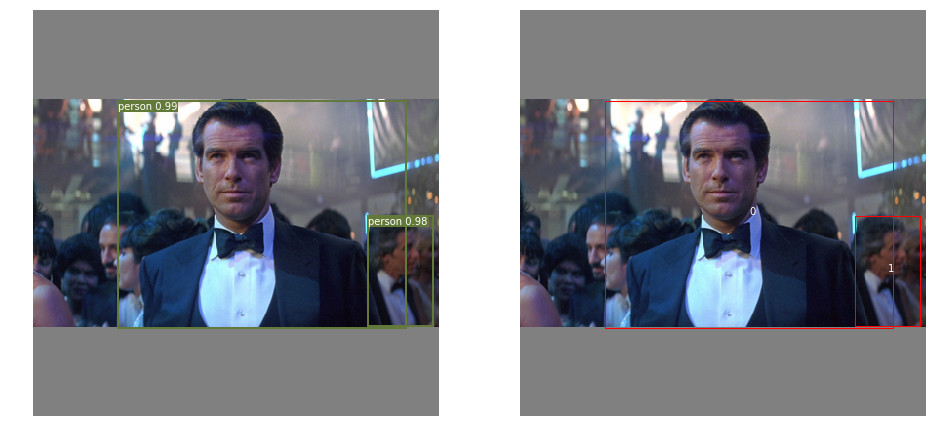

In [19]:
#match portrait
detectObjects("/faceml/sampleimages/pierce2.jpg",  classname="person", requiredSize=2, requiredCount=1,portraitDiff=200)


/faceml/sampleimages/pierce1.jpg : Found  3  count of  ['person']  objects with  2  greater than  5 %
matched as selfie
%Areas: 20.337 7.9521 4.5907 %Diff: 155.7438 73.2219 

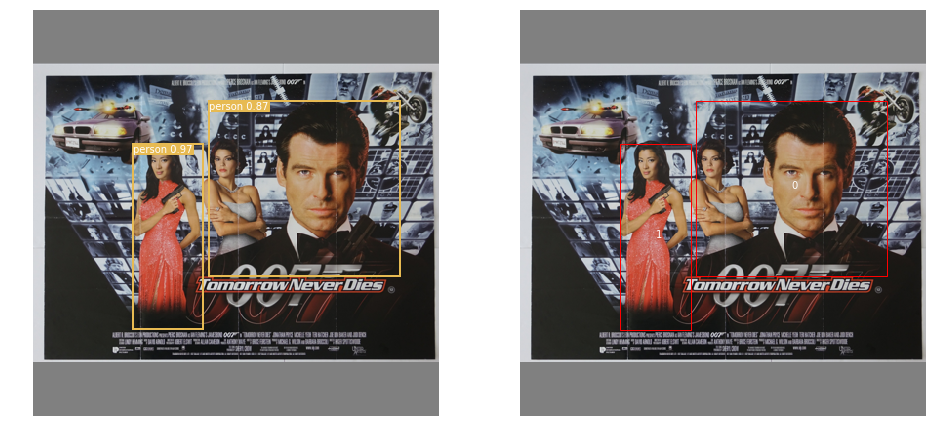

In [20]:
#match as selfie
detectObjects("/faceml/sampleimages/pierce1.jpg",  classname="person", groupDiff=100, selfieDiff=150)


/faceml/sampleimages/craig1.jpg : Found  6  count of  ['person']  objects with  5  greater than  2 %
matched as selfie
%Areas: 27.9055 15.5426 11.3628 6.1026 5.8651 1.6645 %Diff: 79.5419 36.7848 86.1975 4.0479 252.3617 

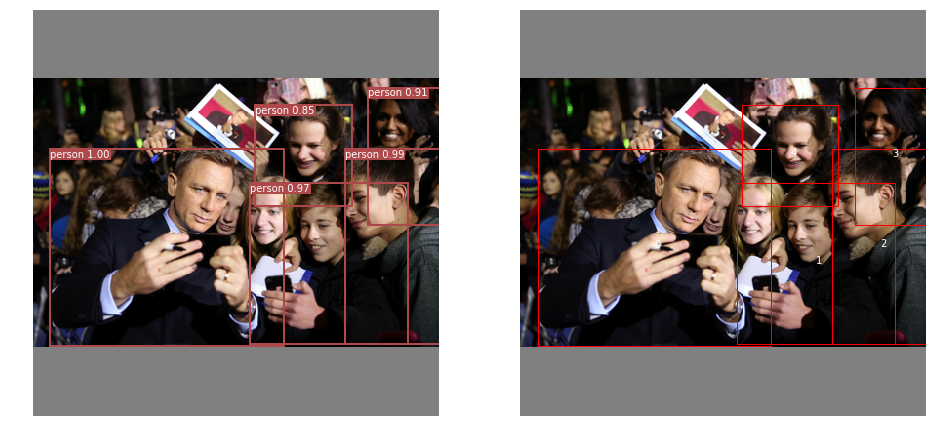

In [21]:
#match selfie
detectObjects("/faceml/sampleimages/craig1.jpg",  classname="person", requiredSize=2, groupDiff=100, selfieDiff=50)

/faceml/sampleimages/newyork.jpg : Found  14  count of  ['person', 'car']  objects with  11  greater than  0.5 %
matched as group
%Areas: 2.6241 2.4636 1.7501 1.3943 1.1845 0.9074 0.8589 0.7584 0.7413 0.5569 0.5083 0.4699 0.4208 0.2496 %Diff: 6.5152 40.7666 25.5167 17.7188 30.5393 5.646 13.2478 2.3126 33.116 9.5447 8.1727 11.6693 68.6118 

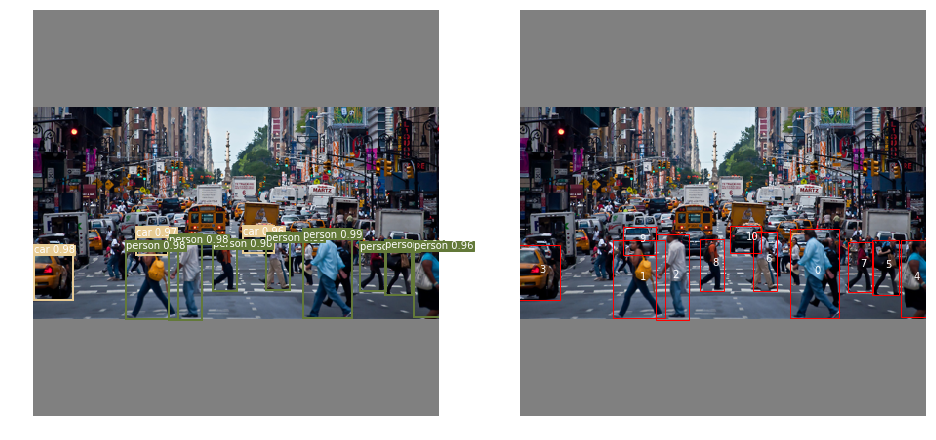

In [22]:
#match person and cars
detectObjects("/faceml/sampleimages/newyork.jpg", requiredSize=0.5, classname="[person] and [car]")

Found 62 objects in /faceml/sampleimages/newyork.jpg
['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'bus', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'backpack', 'backpack', 'backpack', 'handbag', 'handbag', 'handbag']


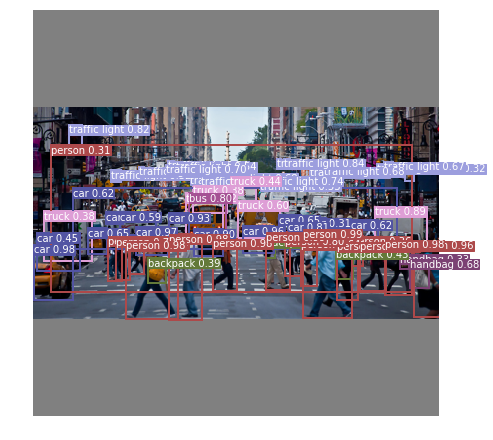

In [23]:
#match person and cars and not bus
detectObjects("/faceml/sampleimages/newyork.jpg", requiredSize=0.5, classname="[person] and [car] and not [bus]")

/faceml/sampleimages/atharva1.jpg : Found  4  count of  ['person', 'car']  objects with  3  greater than  0.5 %
matched as portrait
/faceml/sampleimages/atharva1.jpg : No  ['bus']  objects found
%Areas: 47.0124 1.0124 0.8189 0.1002 %Diff: 4543.5509 23.6263 717.0633 

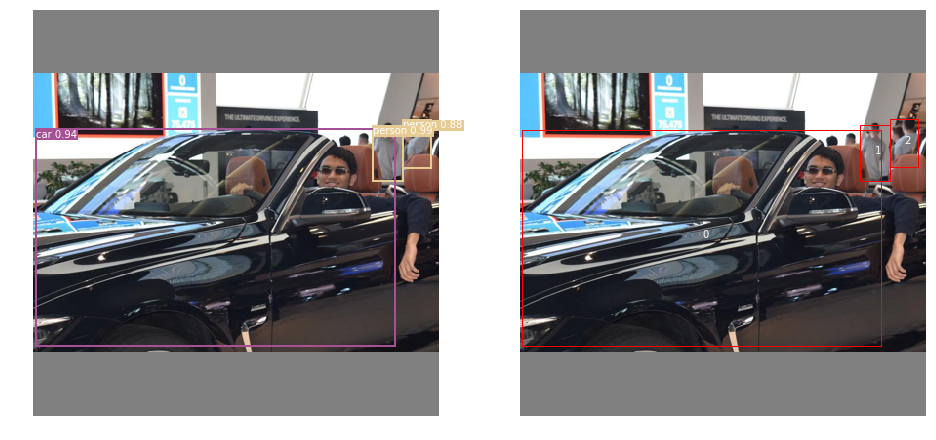

In [25]:
detectObjects('/faceml/sampleimages/atharva1.jpg', requiredSize=0.5, classname="[person] and [car] and not [bus]")

Found 10 objects in /faceml/sampleimages/venice.jpg
['person', 'person', 'person', 'boat', 'boat', 'boat', 'boat', 'boat', 'boat', 'boat']


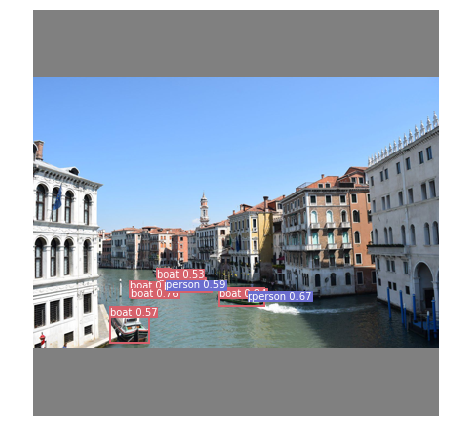

In [33]:
detectObjects('/faceml/sampleimages/venice.jpg', requiredSize=0.2, classname="")

/faceml/sampleimages/venice.jpg : Found  1  count of  ['person', 'boat']  objects with  1  greater than  0.2 %
%Areas: 0.4947 %Diff: 

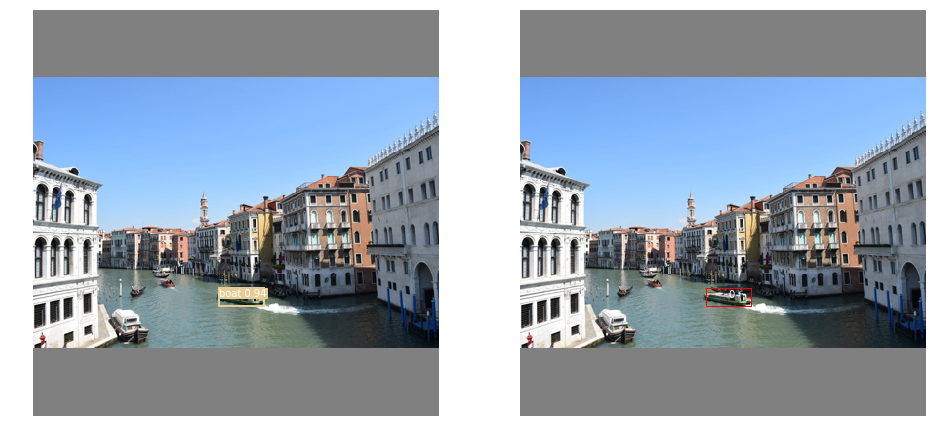

In [34]:
detectObjects('/faceml/sampleimages/venice.jpg', requiredSize=0.2, classname="[person] and [boat]")

/faceml/sampleimages/vatican1.jpg : No  ['person']  objects found
%Areas: %Diff: 

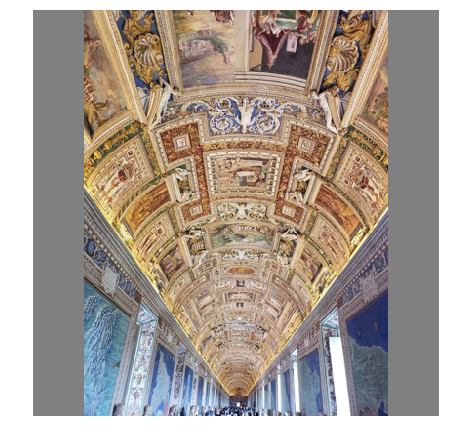

In [24]:
#match not person
detectObjects("/faceml/sampleimages/vatican1.jpg", requiredSize=0.5, classname="not [person]")